# CNN-based Brain Tumour Segmentation Network
## Import packages
Please make sure you have all the required packages installed. If GPU is available, but you want to use CPU to train your model, make sure you add " os.environ['CUDA_VISIBLE_DEVICES'] = '-1' " before "from keras.preprocessing.image import ImageDataGenerator"

In [1]:
import numpy as np 
from tqdm import tqdm
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import shutil
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Data preparation (this step has been done for you)

Images in the original dataset are usually in different sizes, so we need to resize and normalise them to fit the CNN model. Depending on the images you choose to use for training your model, some other preprocessing methods (cropping, zooming, etc.) may be required.

## Split your dataset into training and validation
Validation dataset would not be used to train your network, it is normally for evaluating your model performance and choosing the best set of hyperparameters. Choose the size of your training and validation set yourself.

In [2]:
#uncomment if using linux/macos
!rm -rf TrainSeg ValSeg
!mkdir TrainSeg ValSeg TrainSeg/Yes ValSeg/Yes



img_path = 'Dataset/'
train_list = []
val_list = []
CLASS = 'Yes'
all_files = os.listdir(img_path + CLASS)
files = [item for item in all_files if "img" in item]
random.shuffle(files)
img_num = len(files)
for (n, file_name) in enumerate(files):
    img = os.path.join(img_path,CLASS,file_name)
    seg = os.path.join(img_path,CLASS,file_name.split('_')[0]+'_seg.npy')
    # 80% of images will be used for training, change the number here 
    # to use different number of images for training your model.
    if n < 0.8*img_num:
        shutil.copy(img, os.path.join('TrainSeg/',CLASS,file_name))
        train_list.append(os.path.join('TrainSeg/',CLASS,file_name))
        shutil.copy(seg, os.path.join('TrainSeg/',CLASS,file_name.split('_')[0]+'_seg.npy'))
    else:
        shutil.copy(img, os.path.join('ValSeg/',CLASS,file_name))
        val_list.append(os.path.join('ValSeg/',CLASS,file_name))
        shutil.copy(seg, os.path.join('ValSeg/',CLASS,file_name.split('_')[0]+'_seg.npy'))

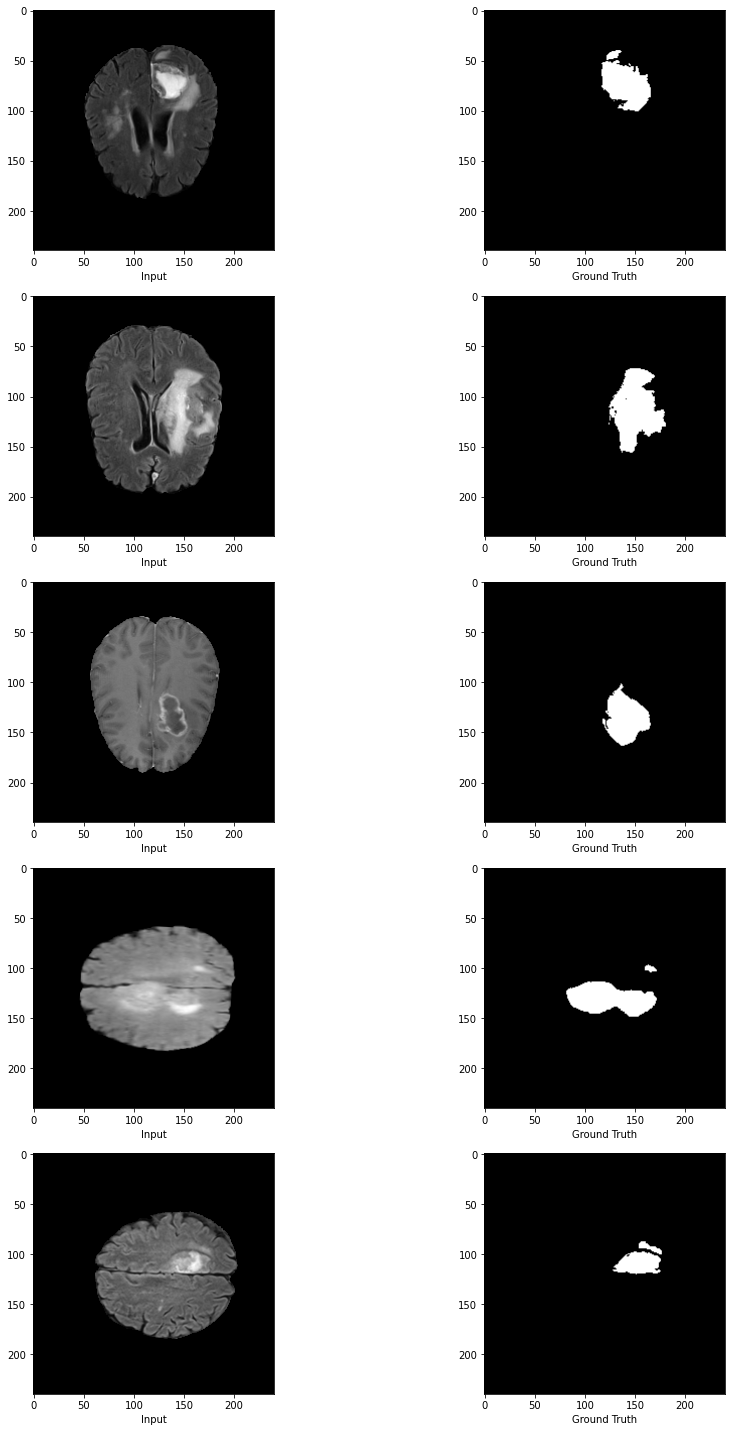

In [3]:
def plot_samples(x,n=10):
    i = n
    j = 2
    plt.figure(figsize=(15,20))
    k = 1
    idx_nums = np.random.randint(len(x),size=n)
    for idx in idx_nums:
        plt.subplot(i,j,k)
        while k%2 != 0:
            plt.imshow(np.load(x[idx])[:,:,0], cmap='gray')
            plt.xlabel("Input")
            k += 1
        plt.subplot(i,j,k)
        plt.imshow(np.load(x[idx].split('_')[0]+'_seg.npy')[:,:], cmap='gray')
        plt.xlabel("Ground Truth")
        k += 1
    plt.tight_layout()
    plt.show()

plot_samples(train_list, n=5)

## Train-time data augmentation
Generalizability is crucial to a deep learning model and it refers to the performance difference of a model when evaluated on the seen data (training data) versus the unseen data (testing data). Improving the generalizability of these models has always been a difficult challenge. 

**Data Augmentation** is an effective way of improving the generalizability, because the augmented data will represent a more comprehensive set of possible data samples and minimizing the distance between the training and validation/testing sets.

There are many data augmentation methods you can choose in this projects including rotation, shifting, flipping, etc.

You are encouraged to try different augmentation method to get the best classification accuracy.

**Question**

Applying data augmentation to medical images may sometimes make the images uninterpretable to human. For instance, a heart may not look like a heart after shearing the image. Would training the model with these uninterpretable images helpful to improving the model performance? Why do you think it is helpful/not helpful?

## Get the data generator ready

You may change the batch size of your training data here. A large batch size or even a batch size that equals to the entire dataset is more likely to get your model to the convergence to the global optima of the loss function, but this is at the cost of computational efficiency and sometimes large batch size would lead to a bad model generalisation. 

There is always a trade-off between large and small batch size. Choose a reasonable batch size here to get the best model performance.

You can add your data augmentation methods here. Some simple example can be found at https://towardsdatascience.com/image-augmentation-using-python-numpy-opencv-and-skimage-ef027e9898da.

In [4]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, batch_size=16, dim=(240,240), n_channels=3,
                 n_classes=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # Add data augmentation here
            X[i,] = np.load(ID)

            # Store segmentation map
            y[i] = np.load(ID[:-8] +'_seg.npy')

        return X, y

In [5]:
train_generator = DataGenerator(train_list)
validation_generator = DataGenerator(val_list)
IMG_SIZE = (240,240)
RANDOM_SEED = 100

In [9]:
def unet(input_size = (240,240,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv4)
    drop4 = Dropout(0.6)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same')(conv5)
    drop5 = Dropout(0.6)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same')(conv9)
    conv10 = Conv2D(1, 1, activation = 'tanh')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    initial_learning_rate =1e-4
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.95,
    staircase=True)
    model.compile(optimizer = Adam(lr_schedule), loss ='binary_crossentropy', metrics = [dice_score])
   # tf.keras.optimizers.Adagrad(lr = 1e-4, decay = 0.9)
    return model

## Define a metric for the performance of the model
Dice score is used here to evaluate the performance of your model.
More details about the Dice score and other metrics can be found at 
https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

In [10]:
def dice_score(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

## Build your own model here
A vanilla U-Net (https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28) structure is given here for the segmentation task. You are encouraged to modify this structure by changing the hyperparameters of this network. More information about the Keras layers including Conv2D, MaxPooling and Dropout can be found at https://keras.io/api/layers/.

## Train your model here
Change the epochs value for different number of epochs you intend to train your network for.

In [11]:
model = unet()
history = model.fit(
    train_generator,
    epochs=7,
    validation_data=validation_generator,
)

Epoch 1/7
497/497 [==============================] - 203s 408ms/step - loss: 0.0358 - dice_score: 0.6536 - val_loss: 0.0266 - val_dice_score: 0.7760
Epoch 2/7
497/497 [==============================] - 202s 406ms/step - loss: 0.0275 - dice_score: 0.7307 - val_loss: 0.0231 - val_dice_score: 0.7823
Epoch 3/7
497/497 [==============================] - 202s 407ms/step - loss: 0.0225 - dice_score: 0.7720 - val_loss: 0.0269 - val_dice_score: 0.7409
Epoch 4/7
497/497 [==============================] - 202s 407ms/step - loss: 0.0208 - dice_score: 0.7877 - val_loss: 0.0182 - val_dice_score: 0.8118
Epoch 5/7
497/497 [==============================] - 203s 408ms/step - loss: 0.0175 - dice_score: 0.8131 - val_loss: 0.0170 - val_dice_score: 0.8157
Epoch 6/7
497/497 [==============================] - 203s 407ms/step - loss: 0.0161 - dice_score: 0.8280 - val_loss: 0.0161 - val_dice_score: 0.8208
Epoch 7/7
497/497 [==============================] - 203s 408ms/step - loss: 0.0156 - dice_score: 0.8323 -

## Save the model
Save your model for testing later.

In [12]:
model.save('trained_seg_model4.h5')

## Run the model on the validation set and plot the result
For running on the test set, change the test_dir value to 'test/'

In [13]:
test_dir = 'ValSeg/'
#load your model here
dependencies = {
    'dice_score': dice_score
}
model = load_model('trained_seg_model.h5', custom_objects=dependencies)
test_list = []
CLASS = 'Yes'
all_files = os.listdir(test_dir + CLASS)
files = [item for item in all_files if "img" in item]
for file_name in files:
    test_list.append(test_dir + CLASS + '/' + file_name)        
test_generator = DataGenerator(test_list[:100], batch_size=1)

predictions = []
x_test = []
y_test = []
accuracy = []
for i in range(test_generator.__len__()):
    x, y = test_generator.__getitem__(i)
    x_test.append(x)
    y_test.append(y[0])
    prediction = model.predict(x)
    prediction[prediction>0.5] = 1
    prediction[prediction<=0.5] = 0
    predictions.append(prediction[0])
    accuracy.append(dice_score(y[0], prediction[0].astype('float64')))
print('Test Score = %.2f' % np.mean(accuracy))

Test Score = 0.78


In [ ]:
def plot_result(x,y,pred,n=10):
    i = n
    j = 3
    plt.figure(figsize=(15,20))
    k = 1
    idx_nums = np.random.randint(len(x),size=n)
    for idx in idx_nums:
        while k%3 != 0: 
            plt.subplot(i,j,k)
            if k%3 == 1:
                plt.imshow(x[idx][0,:,:,0], cmap='gray')
                plt.xlabel("Input")
            if k%3 == 2:
                plt.imshow(y[idx][:,:], cmap='gray')
                plt.xlabel("Ground Truth")
            k += 1
        plt.subplot(i,j,k)
        plt.imshow(pred[idx][:,:,0], cmap='gray')
        plt.xlabel("Prediction")
        k += 1
    plt.tight_layout()
    plt.show()
    
plot_result(x_test, y_test, predictions, n=5)